<a href="https://colab.research.google.com/github/remi-vidal/NLP-ensae/blob/main/notebook_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
<h1><center><strong><font color="chillipepper">Natural Language Processing - ENSAE 2022</font></strong></center></h1>
<h2><center><strong><font color="chillipepper">Poetry Analysis and Generation</font></strong></center></h2>

---

**Authors :** Louis AMRANI (louis.amrani@ensae.fr) and Rémi VIDAL (remi.vidal@ensae.fr)



## Table of contents
* [Imports and Installation](#imports)
* [Data Exploration](#exploration)
* [Classification](#classification)
* [Generation](#generation)

# Imports and Installation <a name="imports"></a>

In [41]:
!pip install datasets

In [42]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchtext.data.utils import get_tokenizer

from collections import Counter
import datasets
from nltk.tokenize import TreebankWordTokenizer, ToktokTokenizer, TweetTokenizer
from tqdm.notebook import tqdm
from termcolor import colored
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Poetry database. Check the cleaning_data.ipynb notebook for more details about the data collection.
url = "https://raw.githubusercontent.com/remi-vidal/NLP-ensae/main/df_cleaned.csv"
df = pd.read_csv(url, index_col=0)

In [ ]:
# !pip3 freeze > requirements.txt

In [ ]:
df.head()

title                 author  \
0   A Lonely Heart In A Thunderstorm          sylviaspencer   
1                   A Lonely Weekend          sylviaspencer   
2                 Lonely In The Dark             nouriblack   
3                      Lonely Burial  Stephen Vincent Benet   
4  Filmscript For A Lonely Afternoon       Michael Shepherd   

                                             content   theme  \
0  A lonely heart sets the table but is she a Mil...  lonely   
1  How bright it is on a Friday, when I am away f...  lonely   
2  I am living in the darkness\nI feel so scared\...  lonely   
3  There were not many at that lonely place,\nWhe...  lonely   
4  walks into deserted playground\nindifferently,...  lonely   

                                          file_title  
0  LonelyPoemsALonelyHeartInAThunderstormPoembysy...  
1   LonelyPoemsALonelyWeekendPoembysylviaspencer.txt  
2     LonelyPoemsLonelyInTheDarkPoembynouriblack.txt  
3  LonelyPoemsLonelyBurialPoembyStephenVincentBen...  
4  LonelyPoemsFilmscriptForALonelyAfternoonPoemby...

# Data Exploration <a name="exploration"></a>

In [ ]:
df.columns

Index(['title', 'author', 'content', 'theme', 'file_title'], dtype='object')

In [ ]:
len(df)

14335

### Sanity check

In [ ]:
#Empty cells
for column in df.columns :
    print(df[column].isna().sum())

0
1
0
0
0


In [ ]:
# No empty cell, except one author. Let's find it :
df[df['author'].isna()]

title author  \
12757  F Silent Fire    NaN   

                                                 content theme  \
12757  Tell me which fight do you fight deep in you\n...  fire   

                           file_title  
12757  FirePoemsFSilentFirePoemby.txt

$\longrightarrow$ The author was missing in the file name. Cannot retrieve it on internet (unknown author probably).

In [ ]:
# Number of different poems in the database
for column in ['title', 'content', 'file_title'] :
    print(len(df[column].unique()))

11665
13737
14335


$\longrightarrow$ No duplicate files in our database, but some poems are affected to several themes. For example :

In [ ]:
df[df['title']== 'The Sick Rose']

title         author  \
147  The Sick Rose  William Blake   
290  The Sick Rose  William Blake   

                                               content theme  \
147  O Rose, thou art sick!\nThe invisible worm\nTh...  rose   
290  O Rose, thou art sick!\nThe invisible worm\nTh...  sick   

                                     file_title  
147  RosePoemsTheSickRosePoembyWilliamBlake.txt  
290  SickPoemsTheSickRosePoembyWilliamBlake.txt

Moreover, some contents have several titles :

In [ ]:
df[df['content'] == (df[df['title'] == 'Personal Identity']['content'].values[0])]

title             author  \
842  Personal Identity As  Hasmukh Amathalal   
895     Personal Identity  Hasmukh Amathalal   

                                               content     theme  \
842  Personal identity\nWomen always need attention...  identity   
895  Personal identity\nWomen always need attention...  identity   

                                            file_title  
842  IdentityPoemsPersonalIdentityAsPoembyHasmukhAm...  
895  IdentityPoemsPersonalIdentityPoembyHasmukhAmat...

### Themes

In [ ]:
print("There are {} different themes in the database :".format(len(df['theme'].unique())))
df['theme'].unique()

There are 144 different themes in the database :


array(['lonely', 'rose', 'sick', 'carpe diem', 'hope', 'home', 'sorrow',
       'future', 'identity', 'passion', 'girl', 'butterfly', 'childhood',
       'memory', 'poem', 'sea', 'greed', 'baby', 'red', 'rainbow',
       'beauty', 'green', 'travel', 'power', 'family', 'evil', 'fear',
       'dark', 'dream', 'soldier', 'beautiful', 'city', 'laughter',
       'lost', 'spring', 'nature', 'sky', 'work', 'june', 'world',
       'racism', 'courage', 'faith', 'chicago', 'justice', 'school',
       'warning', 'happy', 'football', 'death', 'wedding', 'friend',
       'animal', 'culture', 'truth', 'trust', 'silver', 'heaven',
       'poetry', 'birth', 'father', 'january', 'pink', 'swimming',
       'paris', 'marriage', 'hero', 'river', 'money', 'son', 'mother',
       'frog', 'romance', 'crazy', 'joy', 'success', 'loss', 'daughter',
       'sympathy', 'thanks', 'dance', 'funeral', 'lust', 'hair', 'hate',
       'cinderella', 'car', 'peace', 'freedom', 'winter', 'song',
       'running', 'childre

In [ ]:
df['theme'].value_counts()

friend     100
rain       100
lust       100
brother    100
romance    100
          ... 
courage     98
anger       98
sea         98
sister      98
chicago     98
Name: theme, Length: 144, dtype: int64

In [ ]:
df['theme'].value_counts().value_counts()

100    90
99     43
98     11
Name: theme, dtype: int64

$\longrightarrow$ The poems are well distributed within the classes.

### Authors

In [ ]:
print("There are {} different authors in the database.".format(len(df['author'].unique())))

There are 4222 different authors in the database.


<AxesSubplot:>

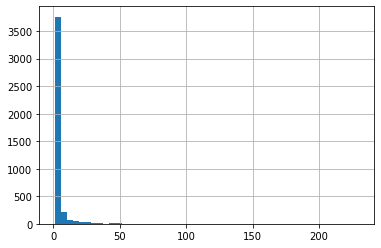

In [ ]:
#Histogram of the number of poems written per author
df['author'].value_counts().hist(bins = 50)

In [ ]:
#Let's print the top twenty : 
df['author'].value_counts()[:20]

Emily Dickinson                   230
johntiongchunghoo                 158
Michael Shepherd                  142
Francis Duggan                    141
Hasmukh Amathalal                 132
Dr A Celestine Raj Manohar M D    114
Aldo Kraas                        113
William Butler Yeats              108
David Harris                      107
Gajanan Mishra                    106
Herbert Nehrlich                  105
Lovina Sylvia Chidi                99
R I C B A S T A S A                95
C J Heck                           89
D+¦nall Dempsey                    85
Uriah Hamilton                     79
Robert William Service             72
Walt Whitman                       68
Robert Louis Stevenson             62
William Blake                      61
Name: author, dtype: int64

### Titles and content

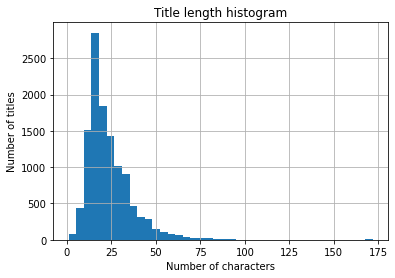

In [ ]:
df.title.drop_duplicates().apply(len).hist(bins=40)
plt.title("Title length histogram")
plt.xlabel("Number of characters")
plt.ylabel("Number of titles")
plt.show()

In [ ]:
# Let's add some basic information about the text : number of "words" in the title and in the content.
# Here we only split by a space. This is a really naive approach because line breaks inside a poem are 
# represented by a "\n", which doesn't split the two adjacent words).

df['title_len'] = df.title.apply(lambda x: len(x.split(' ')) )
df['content_len'] = df.content.apply(lambda x: len(x.split(' ')) )

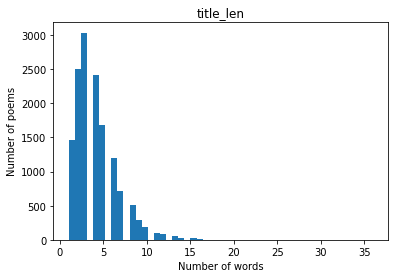

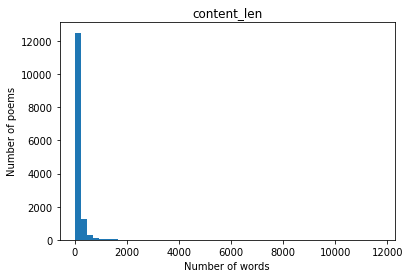

In [ ]:
for col in ['title_len', 'content_len']:
    plt.figure()
    plt.title(col)
    plt.xlabel("Number of words")
    plt.ylabel("Number of poems")
    plt.hist(df[col], bins = 50)
    plt.plot()

$\longrightarrow$ Most of the poems have less than 10 words for the title and less than 500 words for the content.

### Vocabulary

Let's tokenize the content in order to determine the vocabulary size of the corpus :

In [ ]:
tokenizers = [TreebankWordTokenizer(), ToktokTokenizer(), TweetTokenizer()]
for tok in tqdm(tokenizers):
  print('\n')
  print('Using tokenizer: %s' % (tok))
  arr = df.content.drop_duplicates().apply(lambda x: tok.tokenize(x)).array
  arr = [ x for X in arr for x in X] # list flatten

  # The set object transforms a list to the set of unique elements in the list :
  print('The 30 first tokens: %s' % (arr[:30]) )
  print("Vocabulary size:", colored("{0}".format(len(set(arr))), 'red'), " with {0} tokenizer".format(tok))

  0%|          | 0/3 [00:00<?, ?it/s]



Using tokenizer: <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7fa656ecb290>
The 30 first tokens: ['A', 'lonely', 'heart', 'sets', 'the', 'table', 'but', 'is', 'she', 'a', 'Milly', ',', 'a', 'Betty', 'or', 'a', 'Mabel.', 'Tea', ',', 'coffee', ',', 'cakes', 'and', 'ale', 'but', 'outside', 'there', 'blows', 'a', 'gale.']
Vocabulary size: 116763  with <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7fa656ecb290> tokenizer


Using tokenizer: <nltk.tokenize.toktok.ToktokTokenizer object at 0x7fa654969dd0>
The 30 first tokens: ['A', 'lonely', 'heart', 'sets', 'the', 'table', 'but', 'is', 'she', 'a', 'Milly', ',', 'a', 'Betty', 'or', 'a', 'Mabel.', 'Tea', ',', 'coffee', ',', 'cakes', 'and', 'ale', 'but', 'outside', 'there', 'blows', 'a', 'gale.']
Vocabulary size: 110166  with <nltk.tokenize.toktok.ToktokTokenizer object at 0x7fa654969dd0> tokenizer


Using tokenizer: <nltk.tokenize.casual.TweetTokenizer object at 0x7fa654b63950>
The 30 first tokens: ['A', 'lonely', 'he

$⟶$ TweetTokenizer finds less words, probably because it separates every ending point from the previous word. TreebankWordTokenizer and Toktoktokenizer seem quite similar.

### Zipf's law

Zipf's law is an empirical law that refers to the fact that for many types of textual data studied, the rank-frequency distribution is an inverse relation.
With $f_w$ the frenquency of the word $w$ and $k$ the frequency rank of entity $w$, we have :

$$ f_w(k) ~~ \alpha ~~ \dfrac{1}{k^{\theta}}$$

Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log(rank order) and log(frequency). Let's do it on our poetry content :

  0%|          | 0/3 [00:00<?, ?it/s]

Counter({',': 183547, 'the': 111126, 'and': 60127, 'of': 52246, 'to': 50147, 'I': 45367, 'a': 41851, 'in': 34886, 'And': 24784, 'is': 24761, 'you': 24673, ';': 22519, 'my': 20715, 'that': 20482, 'The': 19179, 'with': 18288, '!': 16677, 'it': 16499, 'for': 15482, "'s": 15461, 'me': 13888, 'on': 13216, 'not': 12973, 'be': 12474, 'all': 12388, '?': 12085, 'his': 11410, 'was': 11222, 'as': 10816, '.': 10609, 'your': 10552, 'are': 10478, 'her': 10035, 'from': 9433, 'he': 9260, 'we': 9078, '’': 8968, 'love': 8890, 'have': 8623, ':': 8146, 'will': 7865, 'by': 7851, 'this': 7793, 'they': 7756, 'at': 7748, 'But': 7576, 'so': 7489, 'their': 7206, 'life': 6979, 'one': 6956, 'To': 6946, 'or': 6935, 'A': 6886, '...': 6705, 'can': 6700, 'like': 6555, 'no': 6388, 'but': 6336, 'when': 5877, 'our': 5869, 'In': 5847, 'she': 5460, "'": 5431, 'what': 5422, 'do': 5401, '--': 5387, 'there': 5209, 'That': 5192, 'You': 4981, "''": 4913, 'It': 4901, "'d": 4897, 'He': 4601, 'who': 4588, 'For': 4578, "n't": 4464

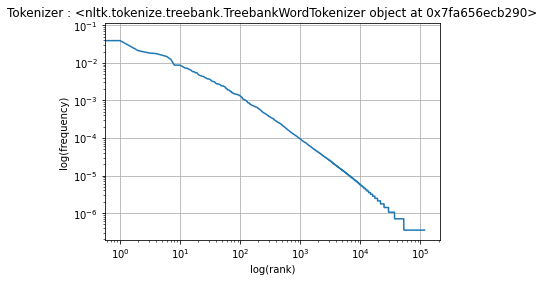

Counter({',': 183542, 'the': 111222, 'and': 60246, 'of': 52276, 'to': 50216, "'": 49550, 'I': 45672, 'a': 41928, 'in': 34939, 'And': 24920, 'you': 24799, 'is': 24323, ';': 22519, 'my': 20732, 'that': 20531, 's': 19319, 'The': 19296, 'with': 18324, '!': 16677, 'it': 16585, 'for': 15515, 'me': 14005, 'on': 13253, 'be': 12516, 'all': 12423, 'not': 12007, '?': 11459, 'his': 11421, 'was': 10990, 'as': 10844, 'your': 10559, 'are': 10425, '.': 10395, 'her': 10055, 'from': 9439, 'he': 9292, 'we': 9115, '’': 8968, 'love': 8947, 'have': 8579, ':': 8148, 'will': 7874, 'by': 7870, 'this': 7829, 'at': 7778, 'they': 7777, 'But': 7623, 'so': 7525, 'their': 7211, 'life': 7003, 'one': 6979, 'or': 6969, 'To': 6961, 'A': 6932, 't': 6677, 'like': 6586, 'can': 6511, 'no': 6413, 'but': 6392, '"': 5974, 'when': 5894, 'our': 5876, 'In': 5864, 'd': 5593, 'she': 5481, 'what': 5449, 'there': 5239, 'That': 5220, 'You': 5054, 'It': 4931, '--': 4862, 'He': 4640, 'For': 4602, 'who': 4595, 'God': 4492, 'out': 4453, '

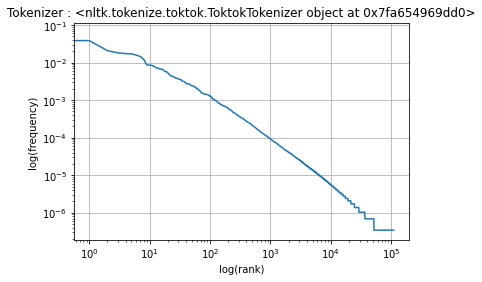

Counter({',': 183712, 'the': 111124, '.': 75812, 'and': 60205, 'of': 52306, 'to': 50232, 'I': 42390, 'a': 41971, 'in': 35027, 'And': 24929, 'you': 24440, 'is': 24382, ';': 22407, 'my': 20728, 'that': 20130, 'The': 19339, 'with': 18349, '!': 16677, 'it': 15874, 'for': 15537, 'me': 14988, "'": 14037, '-': 13628, 'on': 13364, 'be': 12766, 'all': 12653, 'not': 12082, '?': 11905, 'his': 11431, 'was': 11019, 'as': 10836, 'your': 10554, 'are': 10493, 'her': 10236, 'from': 9452, 'love': 9127, '’': 8968, 'he': 8890, 'we': 8660, 'have': 8614, ':': 8095, 'by': 7951, 'will': 7927, 'this': 7913, 'at': 7778, 'But': 7634, 'so': 7571, 'they': 7463, 'their': 7205, 'life': 7044, 'A': 7031, 'one': 6994, 'To': 6973, 'or': 6952, 'like': 6599, 'no': 6430, 'but': 6364, '"': 5974, 'when': 5900, 'In': 5879, 'our': 5873, 'can': 5793, 'what': 5309, 'she': 5257, 'there': 5111, '...': 5038, 'That': 5032, 'You': 4693, 'For': 4615, 'out': 4600, 'him': 4599, 'who': 4496, 'He': 4486, 'more': 4461, 'see': 4419, 'them':

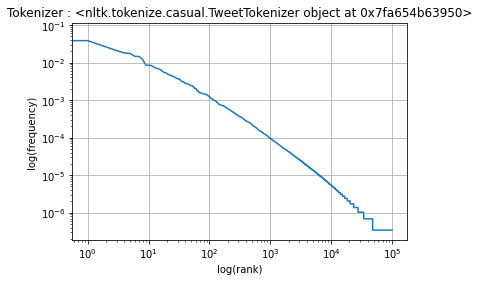

In [ ]:
#We use the code of the TP1 :

for tok in tqdm(tokenizers):
  arr = df.content.drop_duplicates().apply(lambda x: tok.tokenize(x)).array
  arr = [x for X in arr for x in X] # list flatten

  # We use reduce to concatenate all the lists in arr, but we don't use "set" 
  # so that we can count occurencies with a Counter object 
  c = Counter(arr)
  print(c)

  # Formating the counter object to a proper dataset
  d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
  d.columns=['word', 'occurences']
  # Computing frequencies instead of occurences
  nb_total = d.occurences.sum()
  d['freq'] = d.occurences.apply(lambda x: x/nb_total)

  # Sorting by frequency, most frequent word at the top of the df
  d = d.sort_values('freq', ascending=False)

  # Plot
  plt.figure()
  plt.grid()
  plt.xscale('log')  # Using log scale
  plt.yscale('log')  # Using log scale
  plt.xlabel('log(rank)')
  plt.ylabel('log(frequency)')
  plt.title("Tokenizer : {0}".format(tok))
  x = list(range(d.shape[0]))
  plt.plot(x, d.freq)
  plt.show()

$⟶$ Plots are almost linear : Zipf's law seems to be verified on our data.

### Wordcloud by theme

Rather than displaying the most common words in the entire corpus, we can build the wordcloud for a given theme to see the most relevant words.

In [ ]:
def wordcloud_theme(df, theme):
 
  df_theme = df[df['theme'] == theme].copy()

  # We formate the content to have the best possible wordcloud  
  df_theme['tok'] = df_theme.content.apply(lambda x: tok.tokenize(x)).array
  df_theme['tok_cleaned'] = [' '.join(map(str, l)).lower() for l in df_theme['tok']] 
  text = df_theme['tok_cleaned'].values

  # We exclude the most common words by using the default stopwords in the wordcloud package.
  stopwords = set(STOPWORDS)
  stopwords.add("")
  wordcloud = WordCloud(stopwords = stopwords).generate(str(text))

  # Plot
  plt.figure(figsize=(15,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

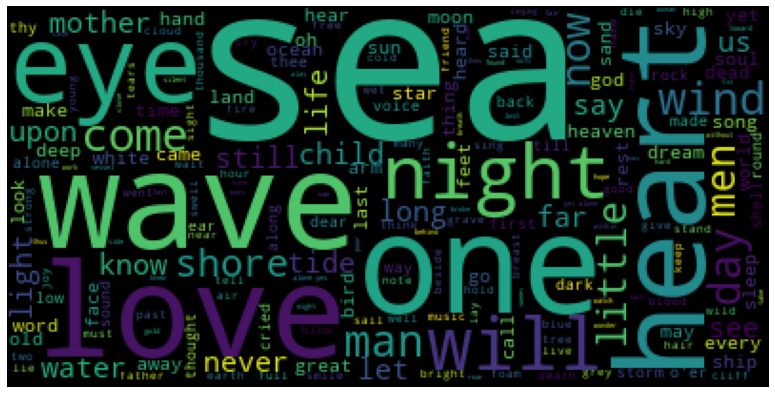

In [ ]:
wordcloud_theme(df,'sea')

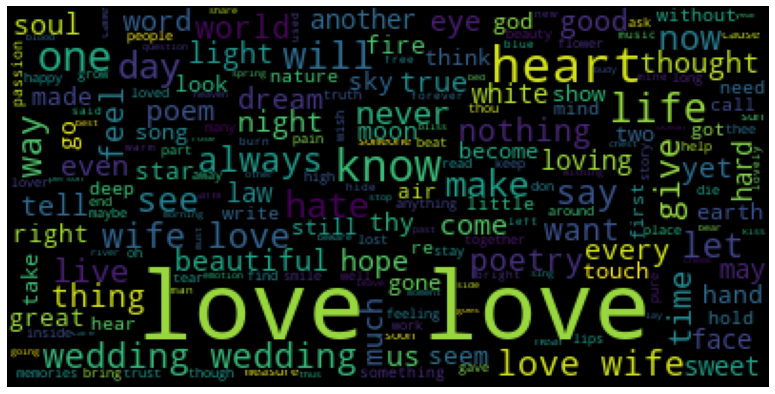

In [ ]:
wordcloud_theme(df,'love')

$⟶$ It seems relevant : we see the lexical fields of sea ('wave', 'ship', 'ocean', 'water', 'storm', 'shore', ...) and love ('wedding', 'wife', 'heart', 'passion', ...).

$⟶$ However, we see the word "love" in the sea wordcloud. It shows that summarizing a poem with a unique theme can be quite imprecise. In anticipation of the next part, it could be harder than expected to classify a content. Let's try it anyway.

# Classification <a name="classification"></a>

## Tokenization

First of all, let's use the tokenizer of our choice in order to clean and  standardize the content of a poem.

In [ ]:
tok = TreebankWordTokenizer()
# tok = ToktokTokenizer()
# tok = TweetTokenizer()

In [ ]:
df['tok'] = df.content.apply(lambda x: tok.tokenize(x)).array
df['tok'] = [' '.join(map(str, l)).lower() for l in df['tok']]

In [ ]:
df['tok'].iloc[0]

"a lonely heart sets the table but is she a milly , a betty or a mabel. tea , coffee , cakes and ale but outside there blows a gale. sash cord windows rattling like chains , thunder and lighting tormenting her brains. a frail old lady who always lays up for tea but no one comes not even her family. as the rain pours down she gives a little frown as she looks at a photo in her wedding gown. a picture of love on her wedding day , a day she never wanted to go away.now all that 's forgotton as the clouds roll together , will her lonely heart stand up to this gale force weather. she draws the curtains and says goodnight to the storm then sits by the fire where its cosy and warm. no visitors tonight she says to the cat who lay curled up on the fireside mat. again she views her wedding day and asks the lord to show her the way.then she holds the cat to her lonely heart so that they will never be apart. the dear old lady died that night and the cat now sits on her burial site ."

## Theme pooling

Classify a poem among more than a hundred themes is clearly unfeasible. Moreover, 100 poems for a single class is not enough for a model to correctly learn. We therefore propose to gather similar topics inside a more general theme.

In [ ]:
love_themes = ['love', 'passion', 'girl', 'baby', 'wedding', 'marriage', 'romance', 'lust', 'husband', 'kiss', 'together', 'romantic']
nature_themes = ['butterfly', 'rainbow', 'travel', 'spring', 'nature', 'sky', 'world', 'animal', 'river', 'winter',
                 'water', 'rain', 'hunting', 'weather', 'beach', 'summer', 'sun', 'snake', 'moon', 'ocean']
sadness_themes = ['lonely', 'sick', 'sorrow', 'fear', 'dark', 'lost', 'loss', 'hate', 'funeral', 'depression',
                  'suicide', 'poverty', 'murder', 'despair', 'anger', 'alone']


len(love_themes), len(nature_themes), len(sadness_themes)

(12, 20, 16)

In [ ]:
def affect_label(theme):
  if theme in love_themes:
    return 0
  elif theme in nature_themes:
    return 1
  elif theme in sadness_themes:
    return 2
  else:
    return np.nan

In [ ]:
df['label'] = df['theme'].apply(affect_label)

# We only keep the poems concerned by our classification.
df_classif = df[df['label'].notna()][['tok', 'label']]
df_classif

tok  label
0      a lonely heart sets the table but is she a mil...    2.0
1      how bright it is on a friday , when i am away ...    2.0
2      i am living in the darkness i feel so scared i...    2.0
3      there were not many at that lonely place , whe...    2.0
4      walks into deserted playground indifferently ,...    2.0
...                                                  ...    ...
14131  i tell you that i see her still at the dark en...    2.0
14132  if god has been good enough to give you a poet...    2.0
14133  all alone , no one here not even a soul is 5ft...    2.0
14134  don ’ t leave me alone , this dark cold night ...    2.0
14135  the sorrow of riverside blossoms inexplicable ...    2.0

[4781 rows x 2 columns]

In [ ]:
# Pytorch requires the labels to be integers.
df_classif = df_classif.astype({'label':'int'}) 

In [ ]:
df_classif['label'].value_counts()

1    1993
2    1590
0    1198
Name: label, dtype: int64

$⟶$ The classes are quite balanced.

## Building dataloader

In [ ]:
from datasets import *

train_dataset = Dataset.from_dict(df_classif)
poem_eval = datasets.DatasetDict({"train":train_dataset})
poem_eval

DatasetDict({
    train: Dataset({
        features: ['tok', 'label'],
        num_rows: 4781
    })
})

In [ ]:
# Let's split the dataset in train/validation/test splits :

from sklearn.model_selection import train_test_split
# we retrieve a list of indices (required for the .select() method of the hugging face dataset object - which is not a dictionary -)
indices = [i for i in range(len(poem_eval['train']))]

# ~67% train, ~16 % val, ~16% test
train_indices, other_indices, _, _ = train_test_split(indices, indices, test_size=0.33, random_state=42)
val_indices, test_indices, _, _ = train_test_split(other_indices, other_indices, test_size=0.5, random_state=42)

print(len(train_indices), len(val_indices), len(test_indices))

3203 789 789


In [ ]:
poem_eval['validation'] = poem_eval['train'].select(val_indices)
poem_eval['test'] = poem_eval['train'].select(test_indices)
poem_eval['train'] = poem_eval['train'].select(train_indices)

In [ ]:
poem_eval['train']['tok'][:3]

['spinning faster and faster , spiraling down , down , depression creates a suffocating heaviness which consumes and smothers your entire being. as i recall this space in time , it seems as though viewing an experience that belongs to a stranger. my physical body defeated , so tired there is no movement. eratic thought patterns that make no sense. who is controlling these thoughts ? my mind is in control , which now belongs to the very dark powerful emotion of depression. this emotion gathers together , confusion , negativity , loss , misery , self hatred , guilt , and doubt , all joining forces and circling faster , causing dizziness and taking me down to a cold , dark place full of sadness. this sadness so overwhelming it comes crashing , over and over like pounding waves , its too dark to see anything , the next wave crashes over with no time for a breath before the next wave floods tears that fall as though they will never stop falling. nothing makes any sense - i am lost , it is d

In [ ]:
poem_eval['train']['label'][:3]

[2, 0, 1]

$⟶$ The first is sadness (ok), the second is love (not really, it talks about political romance...), and the third nature (ok).

In [ ]:
print(Counter(poem_eval['test']['label']))

Counter({1: 334, 2: 269, 0: 186})


### Import pre-trained embeddings

We use the pre-trained embeddings used in TP3-4.

In [ ]:
from torchtext.vocab import vocab, FastText
pretrained_vectors = FastText(language='en')

.vector_cache/wiki.en.vec: 6.60GB [02:54, 37.8MB/s]                            
100%|██████████| 2519370/2519370 [05:17<00:00, 7939.15it/s]


In [ ]:
pretrained_vectors.vectors.size()

torch.Size([2519370, 300])

In [ ]:
pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)

#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

In [ ]:
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=50):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['tok'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['tok']]
  res['label'] = entries['label']
  return res


poem_eval['train'] = poem_eval['train'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
poem_eval['validation'] = poem_eval['validation'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
poem_eval['test'] = poem_eval['test'].map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from torch.utils.data import Dataset

class PoemDataset(Dataset):
    def __init__(self, data, args):
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "tok": np.array(self.data[idx]['tok']),
          "label": np.array(self.data[idx]['label'])
      }
      return item

In [ ]:
# Create DataLoader
from torch.utils.data import Dataset, DataLoader
args = {'bsize': 64}
train_loader = DataLoader(PoemDataset(poem_eval['train'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(PoemDataset(poem_eval['validation'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(PoemDataset(poem_eval['test'], args), batch_size=args['bsize'], num_workers=2, shuffle=True, drop_last=True)

In [ ]:
next(iter(train_loader))['tok'].shape

torch.Size([64, 200])

### Pytorch Model

Here again we reuse parts of the TP3-4. We tried to modify several parameters (add a second hidden layer, modify learning rate, number of epochs, batch size, etc) in order to have the best classification accuracy on the test set, while avoiding overfitting. We kept the ReLu activation function.

In [ ]:
class PoemModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pretrained_vectors=None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(PoemModel, self).__init__()
        # apply the pretrained embeddings to transform our token indices, into vectors
        self.ebd = torch.nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.hidden_linear_layer = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        # self.hidden_linear_layer_2 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.classification_layer = torch.nn.Linear(hidden_dim, output_dim, bias=True)
        # softmax layer to compute class probabilities
        self.softmax = nn.Softmax(dim=1)

        # Dropout strategy (here, 20% of the vector is ignored to prevent overfitting)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.ebd(x)
        x = x.mean(1)
        h1 = torch.relu(self.hidden_linear_layer(x))
        # h2 = torch.relu(self.hidden_linear_layer(x))
        h  = self.dropout(h1) #  h  = self.dropout(h2)
        h = self.classification_layer(h)
        logits = self.softmax(h)
        return logits

In [ ]:
sizes = next(iter(train_loader))['tok'].size()
batchsize = sizes[0]
inputdim  = sizes[1]
print(batchsize, inputdim)        

64 200


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

hiddendim = 300 #dimension of the pretrained vector
outputdim = 3 #because there is 3 classes, i.e. 3 types of poems
# we instanciate the model
poem_model = PoemModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)

# We can look at the model 
poem_model

PoemModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
  print('DEVICE = ', torch.cuda.get_device_name(0))
  
else:
  device = 'cpu'
  print('DEVICE = ', 'CPU')
poem_model.to(device)

DEVICE =  CPU


PoemModel(
  (ebd): Embedding(2519370, 300)
  (hidden_linear_layer): Linear(in_features=300, out_features=300, bias=True)
  (classification_layer): Linear(in_features=300, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
next(poem_model.parameters()).is_cuda

False

In [ ]:
def train(model, optimizer, ep, args):
  model.train()
  # Initialization : empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # Loop over all the training batches (one full epoch)
  for it, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=train_loader.__len__()):
    
    batch = {'tok': batch['tok'].to(device), 'label': batch['label'].to(device)}

    # Put parameters of the model and the optimizer to zero before doing another iteration.
    optimizer.zero_grad()

    # Apply the model on the batch
    logits = model(batch['tok'])

    # To deal with unbalanced data in the batch, we calculate the weights according to their inverse frequency
    b_counter = Counter(batch['label'].detach().cpu().tolist())
    b_weights = torch.tensor( [ sum(batch['label'].detach().cpu().tolist()) / b_counter[label] if b_counter[label] > 0 else 0 for label in list(range(args['num_class'])) ] )
    b_weights = b_weights.to(device)

    # We choose the CrossEntropyLoss, suitable for multiclass classification
    loss_function = nn.CrossEntropyLoss(weight=b_weights)
    loss = loss_function(logits, batch['label'])

    # Backpropagation
    loss.backward()

    # Indicate to the optimizer we've done a step
    optimizer.step()

    # Append the value of the loss for the current iteration
    loss_it.append(loss.item())

    # Get the predicted tags using the maximum probability from the softmax
    _, tag_seq  = torch.max(logits, 1)
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # Simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (str(ep),args['max_eps'] , 'Training', 'loss', sum(loss_it)/len(loss_it), 'acc', sum(acc_it) / len(acc_it)))


In [ ]:
def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """

  # Set the model into a evaluation mode
  model.eval()

  # Intialization : empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # Predicted values and true values
  preds, trues = list(), list()

  # Loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # Set an environnement without any gradient.
    with torch.no_grad():

      # Put the batch to the correct device
      batch = {'tok': batch['tok'].to(device), 'label': batch['label'].to(device)}

      # Apply the model
      logits = model(batch['tok'])

      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(logits, batch['label'])

      # No need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())

      # Get the predicted tags using the maximum probability from the softmax
      _, tag_seq  = torch.max(logits, 1)
      
      # Compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # Extend the predictions and true labels lists so we can compare them later on
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # Compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # Print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( target, 'loss', sum(loss_it)/len(loss_it), 'acc', sum(acc_it) / len(acc_it)))

  # Return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

In [ ]:
import torch.optim as optim

def run_epochs(model, args):

  args['device'] =device

  # We set the optimizer as Adam with the learning rate (lr) set in the arguments
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # Empty list to store validation losses for each epoch
  val_ep_losses = list()
  # Iteration over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # Train the model using our defined function
    train(model, optimizer, ep, args)
    # Apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val_loader, model)
    # Append the validation losses
    val_ep_losses.append(val_loss_it_avg)

  # Return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses
    

In [ ]:
# Here we can specify if we want a GPU or a CPU by setting the cuda argument as -1 for CPU and another index for GPU. If we only have one GPU, put 0.
args.update({'max_eps': 30, 'lr': 0.001, 'device': 'cpu', 'cuda': 0, 'num_class': 3})

print('device', device)
# We instantiate model with pre-trained glove vectors
poem_model = PoemModel(inputdim, hiddendim, outputdim, pretrained_vectors=pretrained_vectors.vectors)
loss_list_val = run_epochs(poem_model, args)

device cpu


Epoch 0::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/30 : Training : (loss 1.095117290019989) (acc 0.3953125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0827496548493702) (acc 0.4778645833333333)


Epoch 1::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/30 : Training : (loss 1.0788230919837951) (acc 0.4740625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0557584861914318) (acc 0.5078125)


Epoch 2::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/30 : Training : (loss 1.0564518189430236) (acc 0.50125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0377920866012573) (acc 0.5234375)


Epoch 3::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/30 : Training : (loss 1.04312096118927) (acc 0.514375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.020290032029152) (acc 0.5299479166666666)


Epoch 4::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/30 : Training : (loss 1.0340743625164033) (acc 0.510625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0209700465202332) (acc 0.5390625)


Epoch 5::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/30 : Training : (loss 1.024410786628723) (acc 0.5190625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0182855029900868) (acc 0.5130208333333334)


Epoch 6::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/30 : Training : (loss 1.0179926478862762) (acc 0.5315625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.018857181072235) (acc 0.5052083333333334)


Epoch 7::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/30 : Training : (loss 1.0106691884994508) (acc 0.5371875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.002499168117841) (acc 0.5403645833333334)


Epoch 8::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/30 : Training : (loss 1.000925611257553) (acc 0.5465625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9975861062606176) (acc 0.5325520833333334)


Epoch 9::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/30 : Training : (loss 0.9960740256309509) (acc 0.5515625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9907377660274506) (acc 0.5403645833333334)


Epoch 10::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/30 : Training : (loss 0.9929407715797425) (acc 0.5528125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9870646198590597) (acc 0.5455729166666666)


Epoch 11::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/30 : Training : (loss 0.9901922726631165) (acc 0.5515625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9876874387264252) (acc 0.5533854166666666)


Epoch 12::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/30 : Training : (loss 0.9848156237602234) (acc 0.5665625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9858560264110565) (acc 0.5390625)


Epoch 13::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/30 : Training : (loss 0.9807456254959106) (acc 0.5665625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 1.0126057316859562) (acc 0.5)


Epoch 14::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/30 : Training : (loss 0.9801952385902405) (acc 0.563125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9911485562721888) (acc 0.5390625)


Epoch 15::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/30 : Training : (loss 0.9744062769412994) (acc 0.569375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9912501921256384) (acc 0.5299479166666666)


Epoch 16::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/30 : Training : (loss 0.9691669154167175) (acc 0.5790625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9784059723218282) (acc 0.5598958333333334)


Epoch 17::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/30 : Training : (loss 0.9656907975673675) (acc 0.581875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9840760330359141) (acc 0.5403645833333334)


Epoch 18::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/30 : Training : (loss 0.9623735046386719) (acc 0.589375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9705765942732493) (acc 0.5572916666666666)


Epoch 19::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/30 : Training : (loss 0.9613048934936523) (acc 0.5875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9649617969989777) (acc 0.5625)


Epoch 20::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/30 : Training : (loss 0.9589837074279786) (acc 0.5909375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9565214167038599) (acc 0.5638020833333334)


Epoch 21::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/30 : Training : (loss 0.9627990186214447) (acc 0.576875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9855250914891561) (acc 0.52734375)


Epoch 22::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/30 : Training : (loss 0.9579535233974457) (acc 0.5890625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9719143062829971) (acc 0.5481770833333334)


Epoch 23::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23/30 : Training : (loss 0.9539757716655731) (acc 0.595625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9560278157393137) (acc 0.5755208333333334)


Epoch 24::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24/30 : Training : (loss 0.9493242573738098) (acc 0.598125)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9751843810081482) (acc 0.5520833333333334)


Epoch 25::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25/30 : Training : (loss 0.9460671949386597) (acc 0.6009375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9670460174481074) (acc 0.5651041666666666)


Epoch 26::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/30 : Training : (loss 0.9454015827178955) (acc 0.605)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9698698272307714) (acc 0.546875)


Epoch 27::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27/30 : Training : (loss 0.9454266846179962) (acc 0.6015625)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9442395319541296) (acc 0.5716145833333334)


Epoch 28::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28/30 : Training : (loss 0.9436097419261933) (acc 0.6071875)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9527198523283005) (acc 0.5859375)


Epoch 29::   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29/30 : Training : (loss 0.9372002172470093) (acc 0.614375)


validation::   0%|          | 0/12 [00:00<?, ?it/s]

validation : (loss 0.9590136905511221) (acc 0.5494791666666666)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  plt.ylabel('Cross Entropy')
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  plt.show()

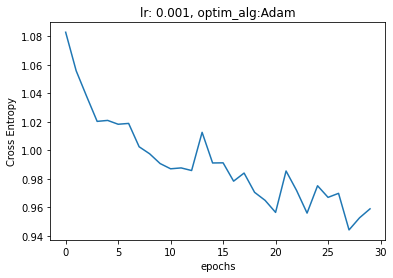

In [ ]:
# Validation loss
plot_loss(loss_list_val)

$⟶$ Ok, the loss goes down.

In [ ]:
# Let's use our model for inference on the test set.
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", test_loader, poem_model)

test::   0%|          | 0/12 [00:00<?, ?it/s]

test : (loss 0.9797448664903641) (acc 0.54296875)


$⟶$ Given our data and the choices we made for the them pooling, 54% is quite a good accuracy for a 3-classes classification.

In [ ]:
# Let's look at the first ten predictions
for t, p in zip(trues[:10], preds[:10]):
  correct = colored('Correct', 'green') if t == p else colored('Mistake', 'red')
  print('true', t, 'predicted', p, correct)

true 1 predicted 0 Mistake
true 1 predicted 1 Correct
true 1 predicted 1 Correct
true 1 predicted 2 Mistake
true 1 predicted 0 Mistake
true 0 predicted 1 Mistake
true 2 predicted 2 Correct
true 0 predicted 1 Mistake
true 1 predicted 1 Correct
true 2 predicted 2 Correct


In [ ]:
names = ["💕", "🌄", "😥"]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))

              precision    recall  f1-score   support

           💕       0.47      0.51      0.49       183
           🌄       0.62      0.59      0.60       323
           😥       0.51      0.51      0.51       262

    accuracy                           0.54       768
   macro avg       0.53      0.54      0.53       768
weighted avg       0.55      0.54      0.54       768



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127748 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128149 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127748 missing from current font.
  font.set_text(s, 0, flags=flags)


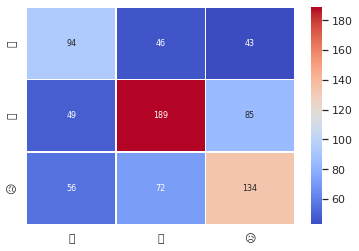

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
import matplotlib.pyplot as plt
import seaborn as sn

cm = confusion_matrix(np.array(trues).flatten(), np.array(preds).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.show()

$⟶$ The model often predicts nature when the true theme is sadness (and the inverse).

# Generation

In [43]:
PAD_IDX = 0#UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<pad>']#['<unk>', '<pad>', '<sos>', '<eos>']

In [44]:
content = df[df.theme == 'lonely'].content  #Lonely content ~2000 sentences
# content = df[df.theme.isin(['love','wedding','kiss'])].content #Love content ~8000 sentences

parsed_data = content.apply(lambda x: x.lower().split("\n"))

corpus = []
for row in parsed_data:
  corpus.extend(row)

len(corpus)

2058

In [45]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [46]:
# Remove punctuation
import string

corpus = [text.translate(str.maketrans('', '', string.punctuation)) for text in corpus]

In [47]:
import en_core_web_sm
tok = en_core_web_sm.load()#spacy.load("en_core_web_sm")#get_tokenizer('spacy', language='en')#TweetTokenizer()

# stoi string to index
# itos index to string

VOC = {'stoi': {}, 'counts': {}, 'nbwords': 0}

def parse_entry(entry):
  tokens = tok(entry.lower().strip())#tok.tokenize(entry.lower().strip())
  for t in tokens:
    t = str(t)
    if t not in VOC['stoi']: 
      VOC['stoi'][t] = VOC['nbwords']
      VOC['counts'][t] = 1
      VOC['nbwords'] += 1
    else:
      VOC['counts'][t] = VOC['counts'][t] + 1


for t in special_symbols: 
  VOC['stoi'][t] = VOC['nbwords']
  VOC['counts'][t] = 1
  VOC['nbwords'] += 1

for entry in tqdm(corpus): 
  parse_entry(entry)

VOC['itos'] = { v:k for k,v in VOC['stoi'].items()}

  0%|          | 0/2058 [00:00<?, ?it/s]

In [48]:
def data_process(corpus, vocab):
    data = list()
    for text in corpus:
        token_list = [vocab['stoi'][str(token)] for token in tok(text.lower().strip())]#tok.tokenize(text.lower().strip())]
        for i in range(1, len(token_list)):
            n_gram_seq = torch.tensor(token_list[:i+1], dtype=torch.long)
            data.append(n_gram_seq)
    return data

train_data = data_process(corpus, VOC)

In [49]:
X = [i[:-1] for i in train_data]   # taking all the words except the last in the input set
y = [i[-1] for i in train_data]    # taking last words in the output set

In [50]:
class CustomDataset(Dataset):
    """custom dataset."""

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.maxlen = 0
        for u in X:
          self.maxlen = max(self.maxlen, len(u))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
      # We pad the X dynamically, so that it has the same length

        sample = F.pad(self.X[idx], (0, self.maxlen - len(self.X[idx])), "constant", VOC['stoi']['<pad>']), self.y[idx]

        return sample

In [ ]:
train_dataset = CustomDataset(X, y)#TensorDataset(X, y)

In [ ]:
VOCAB_SIZE = max(VOC['stoi'].values())+1
EMBEDDING_DIM = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 3

BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, X, h=None, c=None):
        if h is None:
            h, c = self.init_state(X.size(0))
        out = self.embedding(X)
        out, (h, c) = self.lstm(out, (h, c))
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc1(out)
        out = out.view(-1, X.size(1), self.vocab_size)
        out = out[:, -1]
        
        return out, h, c
    
    def init_state(self, batch_size):
        num_l = self.num_layers
        hidden = torch.zeros(num_l, batch_size, self.hidden_size).to(DEVICE)
        cell = torch.zeros(num_l, batch_size, self.hidden_size).to(DEVICE)
        return hidden, cell

In [ ]:
model = Net(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

**Training on 100 epochs is very long in Colab : the checkpoint can be directly loaded by executing the following cell (and skipping the next one)**.

In [ ]:
!wget --content-disposition 'https://github.com/remi-vidal/NLP-ensae/blob/main/loneliness_nopunc_256.pth'

--2022-04-19 18:37:17--  https://github.com/remi-vidal/NLP-ensae/blob/main/loneliness_nopunc_256.pth
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘loneliness_nopunc_256.pth.3’

loneliness_nopunc_2     [ <=>                ] 125.78K  --.-KB/s    in 0.02s   

2022-04-19 18:37:18 (5.04 MB/s) - ‘loneliness_nopunc_256.pth.3’ saved [128798]



In [ ]:
model.load_state_dict(torch.load("loneliness_nopunc_256.pth"))

UnpicklingError: ignored

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
    epoch_loss = 0
    for X, y in train_dataloader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        output, h, c = model(X)
        loss = criterion(output, y)
        epoch_loss += loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5) # Clipping Gradients
        optimizer.step()
    if epoch%5 == 0:
        print(f"Epoch: {epoch+1} Loss:{epoch_loss/len(train_dataloader)}")

In [ ]:
# torch.save(model.state_dict(), "loneliness_nopunc_256.pth")
torch.save(model.state_dict(), "love_nopunc_128.pth")

In [ ]:
seed_text = "i am such a lonely man" #Starting of a poem
# seed_text = "my dearest love i love you madly"
next_words = 50

for i in range(next_words):
    token_list = np.ones(21, dtype=int)
    text_token = np.array([VOC['stoi'][str(token)] for token in tok(seed_text)])
    if len(text_token)>21:text_token = text_token[-21:]
    token_list[:len(text_token)] = text_token
    token_list = torch.from_numpy(token_list).unsqueeze(0).to(DEVICE)
    
    
    out,h,c = model(token_list)
    
    idx = torch.multinomial(nn.Softmax()(out.flatten()), 1)#torch.argmax(out)
    seed_text += " " + VOC['itos'][int(idx)]
    
for i,word in enumerate(seed_text.split()):
    print(word,end=" "),
    if i!=0 and (i+1)%5==0:
        print("\n")